**Name:** LI XINYAN

**EID:** 55670594

# CS5489 - Tutorial 7
## Image Segmentation using Clustering

In this tutorial you will use clustering algorithms to generate a segmentation of an image.  An image segmentation is a separation of an image into regions belonging to distinct objects.
First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best) 
# jpg is better for images
IPython.core.display.set_matplotlib_formats("jpg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
import skimage.io
import skimage.color
import skimage.util
random.seed(100)

## 1. Loading Data and Pre-processing
Next we need to load the data.  Download `imgdb.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the image data.

In [2]:
filelist = glob.glob('imgdb/jpg/*.jpg')
gtpath   = 'imgdb/gtruth/'
if len(filelist) == 0:
    warn.error("Could not find imgdb directory!  " + 
               "Make sure you put it here: " + os.getcwd() )
else:
    imgdata = []
    gtdata  = []
    
    # load image data
    for f in filelist:
        # load image - byte [0 to 255]
        img = skimage.io.imread(f)
        
        (fdir1, fname)  = os.path.split(f)        

        # load GT segmentation (non-consecutive integers)
        gname = gtpath + fname[:-4] + "-gt.png"
        gtimg = skimage.io.imread(gname)
        
        # convert to consecutive integers
        cl = unique(gtimg)
        gtimg0 = gtimg.copy().astype(float64)
        for i in range(len(cl)):
            gtimg0[gtimg==cl[i]] = i
        
        imgdata.append(img)
        gtdata.append(gtimg0)
print(len(imgdata))

14


There are 14 images.  Each image also has a ground-truth segmentation that was created by a human annotation.  Here is an example:

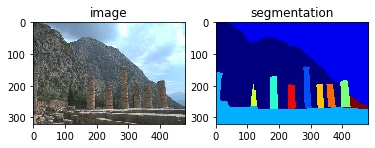

In [3]:
plt.subplot(1,2,1)
plt.imshow(imgdata[6], aspect='equal')
plt.title('image')
plt.subplot(1,2,2)
plt.imshow(gtdata[6], aspect='equal', cmap='jet')
plt.title('segmentation');

## 2. Clustering with Color Features
To segment an image, we will extract features from each pixel location.  Then, we cluster the extracted features into groups.  Pixel location that are clustered into the same group form a segment.

For the features, we will use the "Lab" colorspace, rather than the RGB colors.  Also, we will ignore the "L" feature, which is brightness, resulting in a 2-dimensional color feature space (a, b). Here are a few helper functions: 1) extract Lab features along a regular grid on the image; 2) convert cluster labels into a segmentation image; 3) color a segmentation image using colors from the original image.

In [4]:
def getfeatures(img, segm=None, stepsize=7, use_loc = False):
    """
    getfeatures - extract features from an image
     [X, Y, L] = getfeatures(img, stepsize)
     INPUT
     img      - the image   [type = np.ndarray or Image]
     segm     - the gt segmentation (optional)
     stepsize - window stepsize
     OUTPUT
      X   - the features: each row is a feature vector  [type = np.ndarray]
      Y   - the GT segment labels for each feature (if segm is provided)
      L   - dictionary containing location information of each feature
    """
    winsize = 7 # ensure it is an odd number
    if stepsize > winsize:
        raise Exception('stepsize larger than window size')
    # convert to LAB
    yimg = skimage.color.rgb2lab(img)

    offset = floor((winsize-1)/2)
    sy,sx, sc = img.shape

    if use_loc:
        Xdim = 4
    else:
        Xdim = 2
    
    # extract window patches with stepsize
    patches = skimage.util.view_as_windows(yimg, (winsize, winsize, 3), step=stepsize)    
    psize = patches.shape
    
    # get coordinates of windows
    rangex = arange(psize[1])*stepsize + offset
    rangey = arange(psize[0])*stepsize + offset

    X = zeros((psize[0] * psize[1], Xdim));
    
    if segm is None:
        Y = None
    else:
        Y = zeros((X.shape[0],))
    
    i = 0
    for x in range(psize[1]):
        for y in range(psize[0]):
            myu = mean(patches[y,x,0,:,:,1].flatten())
            myv = mean(patches[y,x,0,:,:,2].flatten())
            myy = int(rangey[y])
            myx = int(rangex[x])
            
            if use_loc:
                X[i,:] = [myu, myv, myx, myy]
            else:
                X[i,:] = [myu, myv]
                
            if Y is not None:
                Y[i] = segm[myy, myx]
                
            i = i + 1 
    
    L = {'rangex':rangex, 'rangey':rangey, 'offset':offset, 'sx':sx, 'sy':sy, \
         'stepsize':stepsize, 'winsize':winsize}
    return X, Y, L

def labels2seg(Y,L):
    """
    labels2segm - form a segmentation image using cluster labels
    segm = labels2segm(Y, L)
    Y - cluster labels for each location
    L - location dictionary from getfeatures
    segm - output segmentation image
    """
    segm = zeros((L['sy'], L['sx']))
    # <= offset if floor((winsize-1)/2)>= floor(stepsize/2) 
    rstep = int(floor(L['stepsize']/2.0)) 
    stepbox = range(-rstep, L['stepsize'] - rstep)
    rx = asarray(L['rangex'], dtype=int) + int(L['offset'])
    ry = asarray(L['rangey'], dtype=int) + int(L['offset'])
    Y_reshaped = Y.reshape((ry.size, rx.size),order='F')
    for i in stepbox:
        for j in stepbox:
            segm[ix_(ry + j, rx + i)] = Y_reshaped
    ## Now fil in the borders if they are missing
    minx = min(rx) + stepbox[0] - 1
    maxx = max(rx) + stepbox[-1] + 1
    miny = min(ry) + stepbox[0] - 1
    maxy = max(ry) + stepbox[-1] + 1

    if 0 <= minx:
        ## fill in left edge
        segm[:, 0:minx+1] = segm[:,minx+1].reshape((-1,1))
    if maxx < L['sx']:
        ## fill in right edge
        segm[:,maxx:] = segm[:,maxx-1].reshape((-1,1))
    if 0 < miny:
        ## fill in top edge
        segm[0:miny+1,:] = segm[miny+1,:].reshape((1,-1))
    if maxy < L['sy']:
        ## fill in bottom edge
        segm[maxy:,:] = segm[maxy-1,:].reshape((1,-1))
    return segm    

def colorsegms(segm, img):
    """
    colorsegm - color a segmentation based on the image
    csegm = colorsegm(segm, img)
    segm = the segmentation image  [type = np.ndarray]
    img = the original image    [type = np.ndarray (or Image)]
    csegm = the colored segmentation -- each segment is colored based on the 
            average pixel color within the segment.
    """
    img = asarray(img).copy()
    if segm.shape[0:2] != img.shape[0:2]:
        raise Exception('The shape of segmentation and image are not consistent') 
    rimg, gimg, bimg = img[:,:,0], img[:,:,1], img[:,:,2]
    for i in range(0, int(max(segm.flatten())) + 1):
        # assume label starts from 1
        ind = (segm == i)
        rimg[ind] = mean(rimg[ind].flatten())
        gimg[ind] = mean(gimg[ind].flatten())
        bimg[ind] = mean(bimg[ind].flatten())
    # handle outliers from DBSCAN
    ind = (segm == -1)
    rimg[ind] = 0
    gimg[ind] = 0
    bimg[ind] = 0
    return img

Next, we use the `getfeatures` function to extract features from an image.  `X` contains the feature vectors. `L` contains information about where each features was extracted, which is used later generate the segmentation.

(3060, 2)


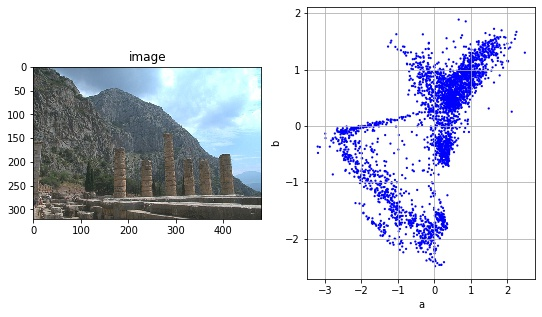

In [5]:
# image to use
img = imgdata[6]
gt  = gtdata[6]

# extract features, each row is a feature vector
Xo,Ytrue, L = getfeatures(img, gt)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()  
X = scaler.fit_transform(Xo)

# view the image
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(img, interpolation='nearest')
plt.title("image")

# view the features
plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c='b', s=5, edgecolor='none')
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Here is the segmented image, with the segment labels shown as colors.  The goal is to recoever these labels using clustering. 

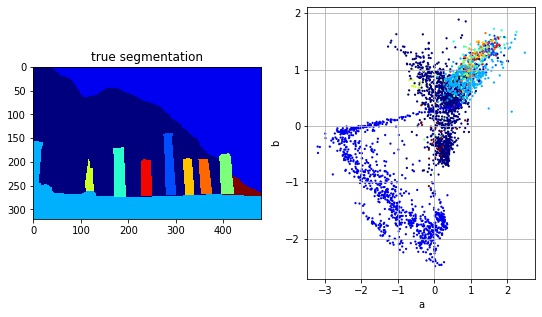

In [6]:
# view the image
plt.figure(figsize=(9,5))

plt.subplot(1,2,1)
plt.imshow(gt, interpolation='nearest', cmap='jet')
plt.title("true segmentation")

# view the features
plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=Ytrue, s=5, edgecolor='none', cmap='jet')
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Now use a clustering algorithm to group the data into 5 clusters.

In [7]:
### INSERT YoUR CODE HERE

In [8]:
# K-means
km = cluster.KMeans(n_clusters=5, random_state=2, n_jobs=-1)
Y1 = km.fit_predict(X)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Once you have the cluster labels (Y), use the below code to generate the segmentation image and view it.  You can also view the scatter plot with `showscatter`.

In [9]:
def showsegm(segm, img):
    "show a segmentation"
    
    # fill segmentation with colors from the image
    csegm = colorsegms(segm, img)
    
    # view the images, segmentation, and ground-truth
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(img, interpolation='nearest')
    plt.title('image')
    plt.subplot(1,3,2)
    plt.imshow(segm, interpolation='nearest', cmap='jet')
    plt.title('segmentation')
    plt.subplot(1,3,3)
    plt.imshow(gt, interpolation='nearest', cmap='jet')
    plt.title("ground truth")
    
    return segm

def showscatter(X,Y):
    "show a scatter plot of clusters"
    
    if X.shape[1] == 2:
        plt.figure()
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.grid(True)
        plt.xlabel('a')
        plt.ylabel('b')
    else:
        plt.figure(figsize=(12,3))

        plt.subplot(1,4,1)
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('a'); plt.ylabel('b'); plt.grid(True)

        plt.subplot(1,4,2)
        plt.scatter(X[:,2], X[:,3], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('x-pos'); plt.ylabel('y-pos'); plt.grid(True)

        plt.subplot(1,4,3)
        plt.scatter(X[:,2], X[:,0], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('x-pos'); plt.ylabel('a'); plt.grid(True)

        plt.subplot(1,4,4)
        plt.scatter(X[:,3], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('y-pos'); plt.ylabel('b'); plt.grid(True)
        
        plt.tight_layout()

In [10]:
# Merge functions together
def showresult(Y):
    segm = labels2seg(Y, L)
    showsegm(segm, img)
    showscatter(X,Y)
    
    return segm

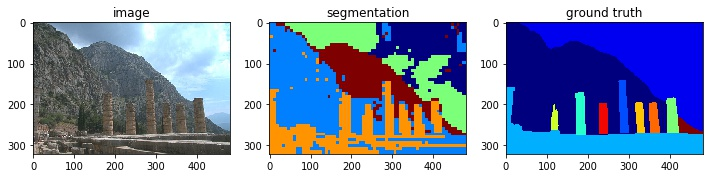

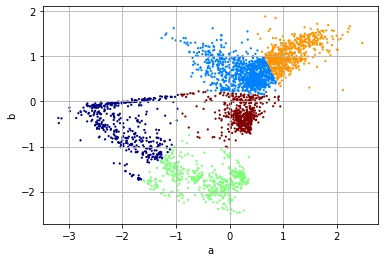

In [11]:
segm = showresult(Y1)

Next we evaluate the segmentation with the ground-truth provided by a human annotator.  We cannot just check that the cluster assignments for each pixel are the same, since the cluster indices can be permuted.  We will use the _Adjusted Rand Index_, which calculates how often a pair of pixels is assigned correctly to the same cluster or not.  Use the below code to calculate the ARI. Higher values are better, and the maximum value is 1. 

In [12]:
# calculate ARI
# ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
ari = metrics.adjusted_rand_score(Ytrue, Y1)
print("ARI =",ari)

ARI = 0.4104988588155676


Try different clustering algorithms and settings (K, bandwidth, etc) to get the best segmentation as measured by ARI. 

In [13]:
### INSERT YOUR CODE HERE

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


ARI = 0.41075486988739107


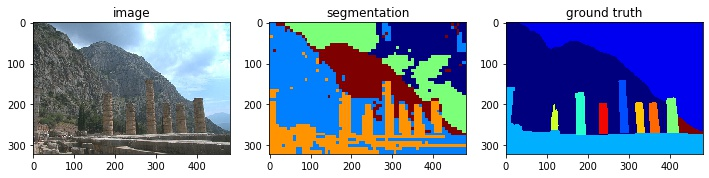

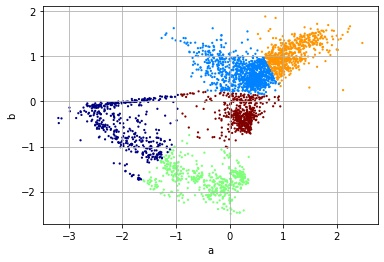

In [14]:
# 1. K-means Clustering
km = cluster.KMeans(init='k-means++', n_clusters=5, random_state=1, n_jobs=-1, n_init=20)
Y1 = km.fit_predict(X)

# calculate ARI of Y1
segm = showresult(Y1)
ari = metrics.adjusted_rand_score(Ytrue, Y1)
print("ARI =",ari)

ARI = 0.41284134723583904


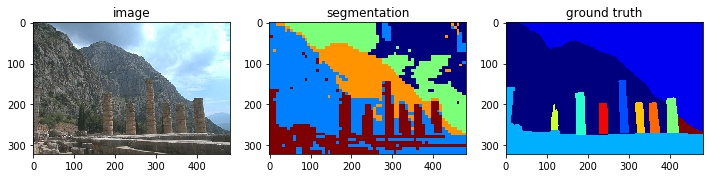

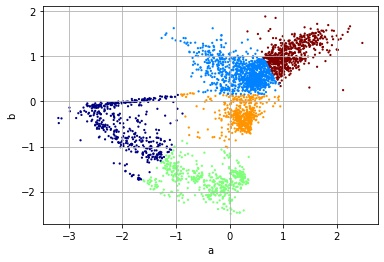

In [15]:
# 2. MiniBatchKMeans Clustering
mbk = cluster.MiniBatchKMeans(init='k-means++', n_clusters=5, random_state=1, n_init=20)
Y2 = mbk.fit_predict(X)

# calculate ARI of Y2
segm = showresult(Y2)
ari = metrics.adjusted_rand_score(Ytrue, Y2)
print("ARI =",ari)

ARI = 0.350152739285423


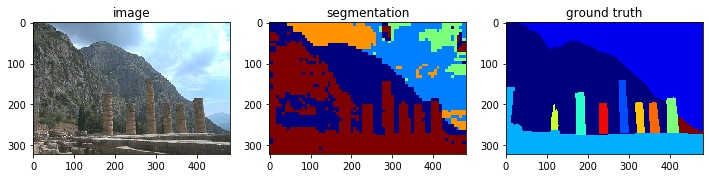

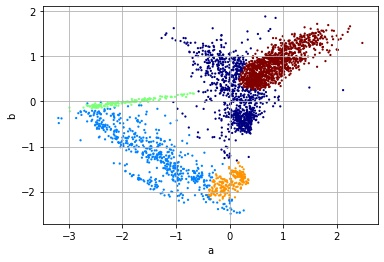

In [16]:
# 3. GMM Clustering
gmm = mixture.GaussianMixture(covariance_type='full', n_components=5, random_state=1, n_init=20)
Y3 = gmm.fit_predict(X)

# calculate ARI of Y3
segm = showresult(Y3)
ari = metrics.adjusted_rand_score(Ytrue, Y3)
print("ARI =",ari)

ARI = 0.25919671046355214


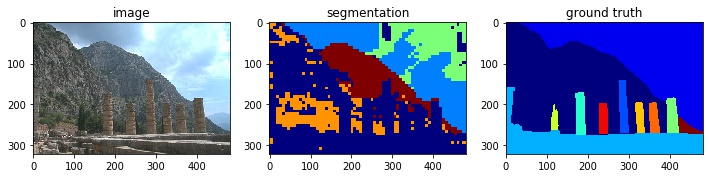

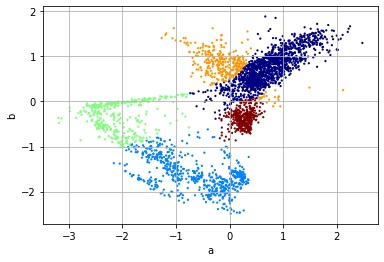

In [17]:
# 4. Dirichlet Process GMM Clustering
dpgmm = mixture.BayesianGaussianMixture(covariance_type='full', n_components=5, random_state=1, n_init=20,)
Y4 = dpgmm.fit_predict(X)

# calculate ARI of Y4
segm = showresult(Y4)
ari = metrics.adjusted_rand_score(Ytrue, Y4)
print("ARI =",ari)

ARI = 0.2808580792247503


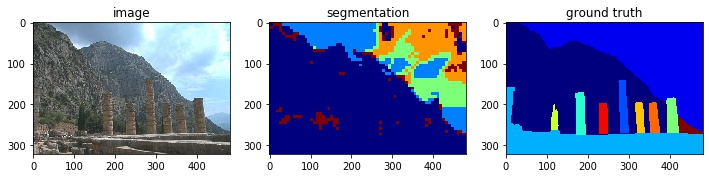

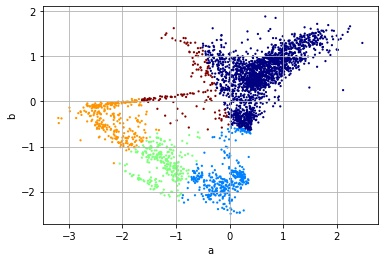

In [18]:
# 5. MeanShift (does not require specifying the number of clusters in advance)
ms = cluster.MeanShift(bandwidth=0.85, bin_seeding=False, n_jobs=-1)
Y5 = ms.fit_predict(X)

# calculate ARI of Y5
segm = showresult(Y5)
ari = metrics.adjusted_rand_score(Ytrue, Y5)
print("ARI =",ari)

ARI = 0.5336164892203796


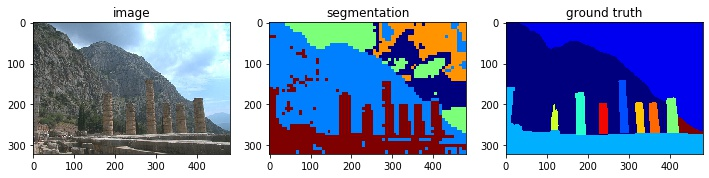

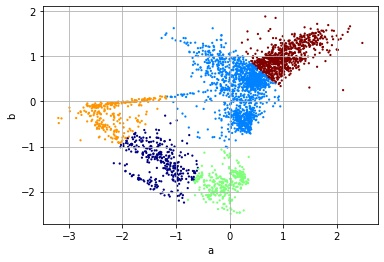

In [19]:
# 6. Spectral Clustering
sc = cluster.SpectralClustering(n_clusters=5, gamma=1, assign_labels='discretize', n_jobs=-1, random_state=1)
Y6 = sc.fit_predict(X)

# calculate ARI of Y6
segm = showresult(Y6)
ari = metrics.adjusted_rand_score(Ytrue, Y6)
print("ARI =",ari)

ARI = 0.4397291485821988


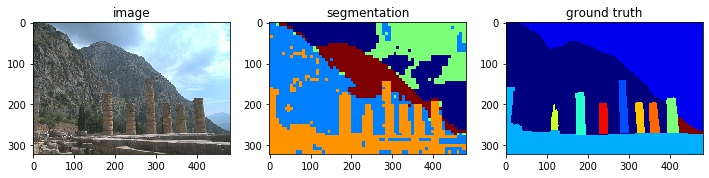

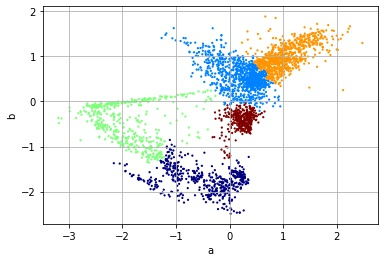

In [20]:
# 7. Agglomerative Clustering
ac = cluster.AgglomerativeClustering(n_clusters=5)
Y7 = ac.fit_predict(X)

# calculate ARI of Y7
segm = showresult(Y7)
ari = metrics.adjusted_rand_score(Ytrue, Y7)
print("ARI =",ari)

## Which algorithm performs the best?  Why?

I think spectral clustering (the 6th algorithm) performs the best for the following reasons:
1. It has the highest ARI score that suggests more pairs of pixels are assigned correctly to the same cluster;
2. The segmentation result of the spectral clustering is closer to the ground truth;
3. The segmentation result makes sense when comparing to the original image (the mountain and the front stones are clusted to different group);
4. The segmentation results of the K-means, MiniBatchKMeans have less cross region, which might mean the boundary between clusters are clearer and smoother (spatially smooth);
5. The agglomerative clustering and spectral clustering are performing not bad but their segmentation results seem to have more noise (more cross region and not spatially smooth).

## 3. Color and Position Features
You may notice that the segmentation is not spatially smooth -- that is, there are some "loner" pixels that are not the same cluster as the surrounding pixels.  This is because we are only clustering color.  One way to fix this is to include the (x,y) coordinate of the pixel as part of the feature vector.  This way, clusters will have pixels that are spatially close together.

The below code extracts a 4-dimensional feature vector, where the first 2 features are the color channels and the last 2 features are the position.

In [21]:
# extract features with location
Xo,Ytrue,L = getfeatures(img, gt, use_loc=True)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()  
X = scaler.fit_transform(Xo)

# rescale position features
# larger values emphasize clustering by position more
X[:,2:4] *= 0.5

(3060, 4)


Here are plots of the 4 features.

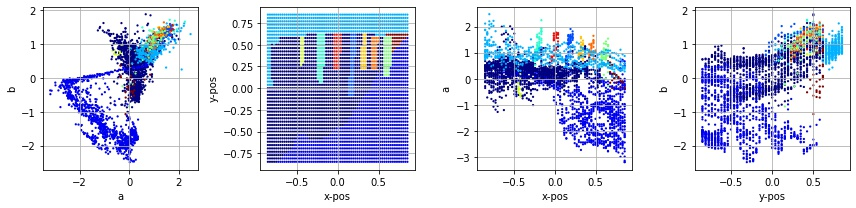

In [22]:
showscatter(X, Ytrue)

Run clustering algorithms on the 4-dimensional data.  Try different algorithms and parameters to get the best ARI.

In [23]:
### INSERT YOUR CODE HERE

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


ARI = 0.45290193467416134


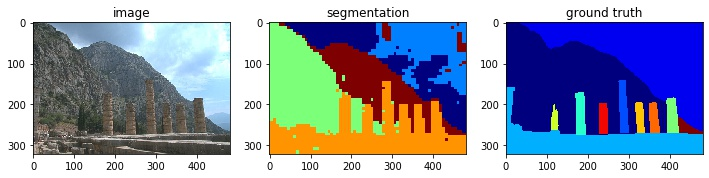

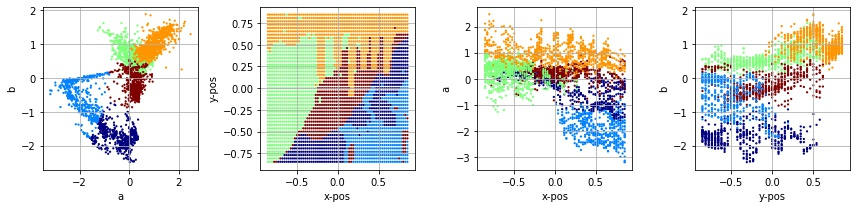

In [24]:
# 1. K-means Clustering
# km = cluster.KMeans(init='k-means++', n_clusters=5, random_state=1, n_jobs=-1, n_init=20)
km = cluster.KMeans(init='random', n_clusters=5, random_state=1, n_jobs=-1, n_init=20)

Y1 = km.fit_predict(X)

# calculate ARI of Y1
segm = showresult(Y1)
ari = metrics.adjusted_rand_score(Ytrue, Y1)
print("ARI =",ari)

ARI = 0.45608016408977614


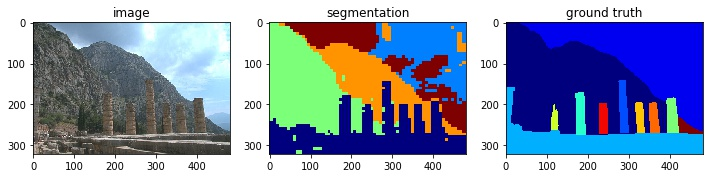

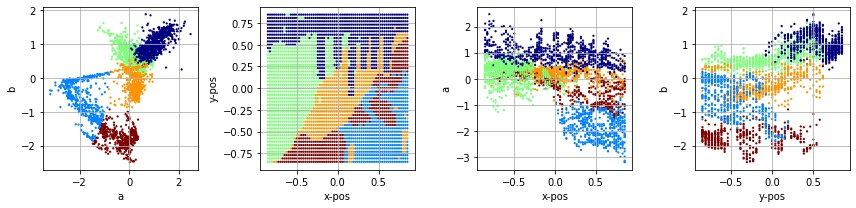

In [25]:
# 2. MiniBatchKMeans Clustering
# mbk = cluster.MiniBatchKMeans(init='k-means++', n_clusters=5, random_state=1, n_init=20)
mbk = cluster.MiniBatchKMeans(init='k-means++', n_clusters=5, random_state=1, n_init=20, reassignment_ratio=1)
Y2 = mbk.fit_predict(X)

# calculate ARI of Y2
segm = showresult(Y2)
ari = metrics.adjusted_rand_score(Ytrue, Y2)
print("ARI =",ari)

ARI = 0.6507466093785076


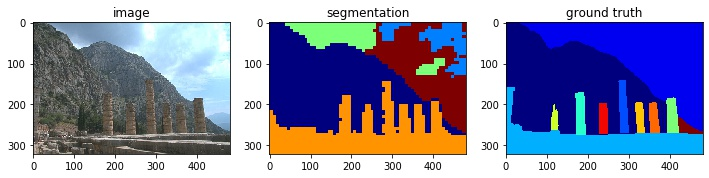

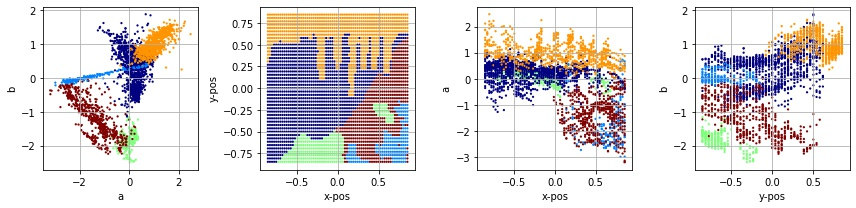

In [26]:
# 3. GMM Clustering
gmm = mixture.GaussianMixture(covariance_type='full', n_components=5, random_state=1, n_init=20)
# gmm = mixture.GaussianMixture(covariance_type='tied', n_components=5, random_state=1, n_init=20)
# gmm = mixture.GaussianMixture(covariance_type='spherical', n_components=5, random_state=1, n_init=20)
# gmm = mixture.GaussianMixture(covariance_type='diag', n_components=5, random_state=1, n_init=20)

Y3 = gmm.fit_predict(X)

# calculate ARI of Y3
segm = showresult(Y3)
ari = metrics.adjusted_rand_score(Ytrue, Y3)
print("ARI =",ari)

ARI = 0.5932729389740278


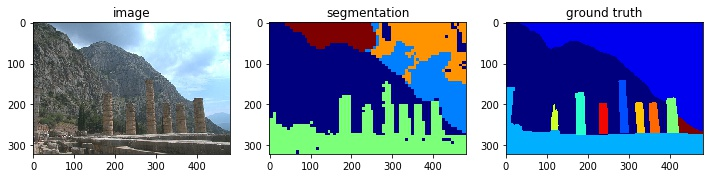

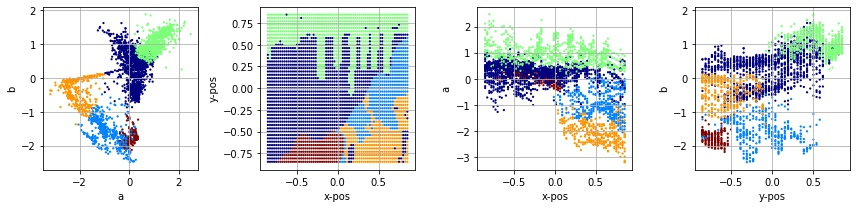

In [27]:
# 3. BayesianGaussianMixture Clustering
# gmm = mixture.BayesianGaussianMixture(covariance_type='full', n_components=5, random_state=1, n_init=20)
# gmm = mixture.BayesianGaussianMixture(covariance_type='tied', n_components=5, random_state=1, n_init=20)
gmm = mixture.BayesianGaussianMixture(covariance_type='spherical', n_components=5, random_state=1, n_init=20)
# gmm = mixture.BayesianGaussianMixture(covariance_type='diag', n_components=5, random_state=1, n_init=20)

Y3 = gmm.fit_predict(X)

# calculate ARI of Y3
segm = showresult(Y3)
ari = metrics.adjusted_rand_score(Ytrue, Y3)
print("ARI =",ari)

ARI = 0.5932729389740278


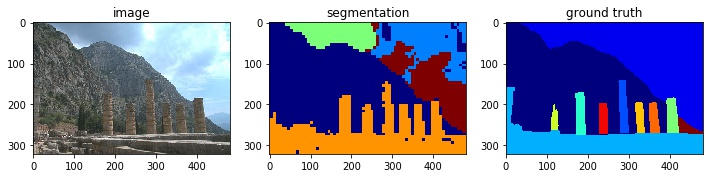

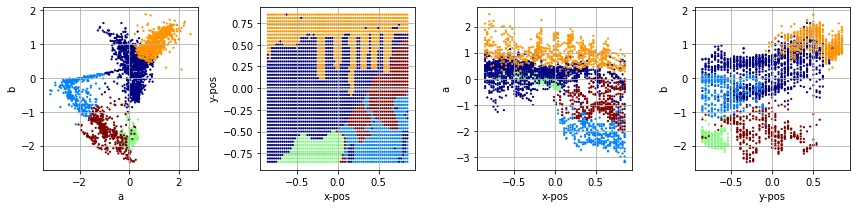

In [28]:
# # 4. Dirichlet Process GMM Clustering
# dpgmm = mixture.BayesianGaussianMixture(covariance_type='full', n_components=5, random_state=1, n_init=20,
#                                         weight_concentration_prior_type='dirichlet_distribution')
# dpgmm = mixture.BayesianGaussianMixture(covariance_type='diag', n_components=5, random_state=1, n_init=20,
#                                         weight_concentration_prior_type='dirichlet_distribution')
# dpgmm = mixture.BayesianGaussianMixture(covariance_type='tied', n_components=5, random_state=1, n_init=20,
#                                         weight_concentration_prior_type='dirichlet_distribution')
dpgmm = mixture.BayesianGaussianMixture(covariance_type='spherical', n_components=5, random_state=1, n_init=20,
                                        weight_concentration_prior_type='dirichlet_distribution')
Y4 = dpgmm.fit_predict(X)

# calculate ARI of Y4
segm = showresult(Y4)
ari = metrics.adjusted_rand_score(Ytrue, Y4)
print("ARI =",ari)

ARI = 0.39336531383688167


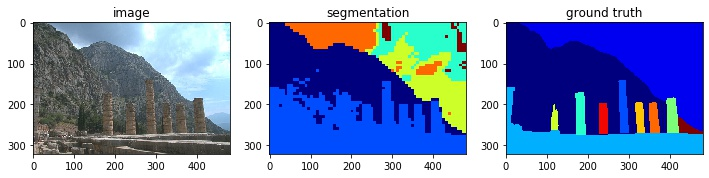

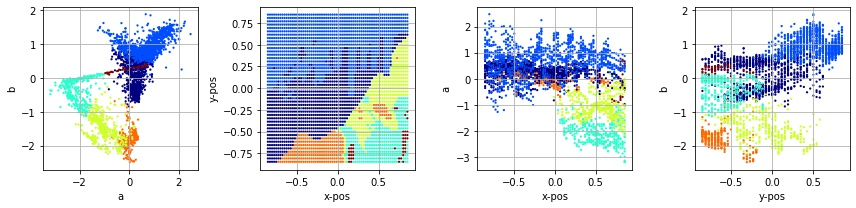

In [29]:
# 5. MeanShift (does not require specifying the number of clusters in advance)
# ms = cluster.MeanShift(bandwidth=0.05, bin_seeding=False, n_jobs=-1)
# ms = cluster.MeanShift(bandwidth=0.55, bin_seeding=False, n_jobs=-1)
ms = cluster.MeanShift(bandwidth=0.75, bin_seeding=False, n_jobs=-1)
# ms = cluster.MeanShift(bandwidth=0.95, bin_seeding=False, n_jobs=-1)
Y5 = ms.fit_predict(X)

# calculate ARI of Y5
segm = showresult(Y5)
ari = metrics.adjusted_rand_score(Ytrue, Y5)
print("ARI =",ari)

ARI = 0.5941304967449689


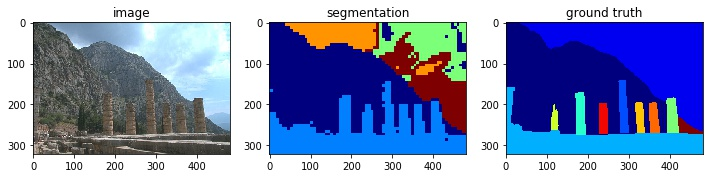

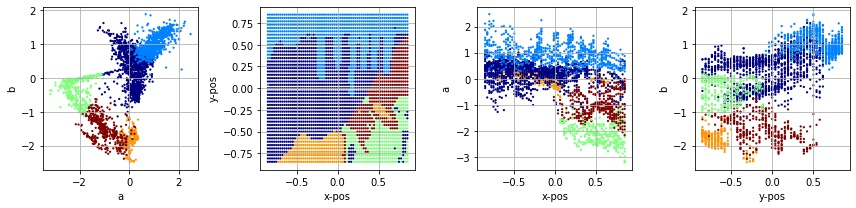

In [30]:
# 6. Spectral Clustering
# sc = cluster.SpectralClustering(n_clusters=5, gamma=1, assign_labels='discretize', n_jobs=-1, random_state=1)
# sc = cluster.SpectralClustering(n_clusters=5, gamma=1e-1, assign_labels='discretize', n_jobs=-1, random_state=1)
# sc = cluster.SpectralClustering(n_clusters=5, gamma=1e-2, assign_labels='discretize', n_jobs=-1, random_state=1)
# sc = cluster.SpectralClustering(n_clusters=5, gamma=1e-3, assign_labels='discretize', n_jobs=-1, random_state=1)

sc = cluster.SpectralClustering(n_clusters=5, gamma=1, assign_labels='kmeans', n_jobs=-1, random_state=1)
# sc = cluster.SpectralClustering(n_clusters=5, gamma=1e-1, assign_labels='kmeans', n_jobs=-1, random_state=1)
# sc = cluster.SpectralClustering(n_clusters=5, gamma=1e-2, assign_labels='kmeans', n_jobs=-1, random_state=1)
# sc = cluster.SpectralClustering(n_clusters=5, gamma=1e-3, assign_labels='kmeans', n_jobs=-1, random_state=1)

Y6 = sc.fit_predict(X)

# calculate ARI of Y6
segm = showresult(Y6)
ari = metrics.adjusted_rand_score(Ytrue, Y6)
print("ARI =",ari)

ARI = 0.6134752829345756


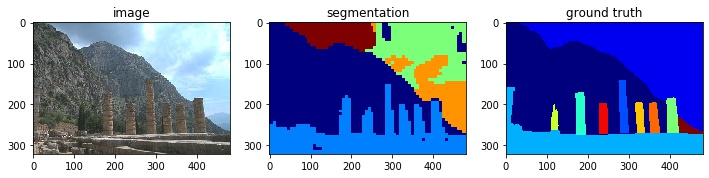

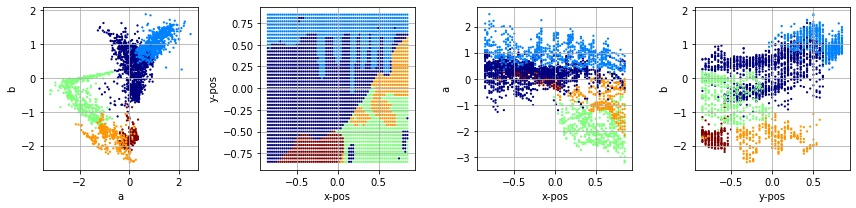

In [31]:
# 7. Agglomerative Clustering
# ac = cluster.AgglomerativeClustering(n_clusters=5, affinity='euclidean')
# ac = cluster.AgglomerativeClustering(n_clusters=5, linkage='average', affinity='l1')
# ac = cluster.AgglomerativeClustering(n_clusters=5, linkage='average', affinity='l2')
# ac = cluster.AgglomerativeClustering(n_clusters=5, linkage='average', affinity='cosine')
ac = cluster.AgglomerativeClustering(n_clusters=5, linkage='average', affinity='manhattan')

# ac = cluster.AgglomerativeClustering(n_clusters=5, linkage='complete', affinity='l1')
# ac = cluster.AgglomerativeClustering(n_clusters=5, linkage='complete', affinity='l2')
# ac = cluster.AgglomerativeClustering(n_clusters=5, linkage='complete', affinity='manhattan')


# “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”.

Y7 = ac.fit_predict(X)

# calculate ARI of Y7
segm = showresult(Y7)
ari = metrics.adjusted_rand_score(Ytrue, Y7)
print("ARI =",ari)

## Which method performs the best?  Why?

I think GaussianMixture clustering (the 6th algorithm) performs the best for the following reasons:
1. It has the highest ARI score that suggests more pairs of pixels are assigned correctly to the same cluster;
2. The GaussianMixture clustering can produce clusters with clear and smooth region (there are less cross regions between different clusters);
3. The clustered color and position features are separated reasonably in the plots;
4. The segmentation result of the GaussianMixture clustering is closer to the ground truth and makes sense when comparing to the original image (the mountain and the front stones are clusted to different group);
5. The segmentation result of the GaussianMixture clustering seem to have smaller noise (less cross region and spatially smooth).

For similar reasons, the performance of agglomerative clustering and spectral clustering are also scceptable.

## Does including the position features improve the segmentation results?

Yes!
1. The ARI scores are improved about 0.1 in average for all the clustering methods;
2. Including the position features helps to reduce noise in the segmentation results (it results in less cross region and make the segmentation result spatially smooth);
3. Including the position features also helps to interprete the segmentation results. We can observe that neighboring regions (position) are tend to be clustered into one group.
4. After including the position features, all the clustering methods now can cluster the mountain into one group (rather than two before including the position features).